# 強化学習
### 懸案すべき事項
- 果たしてネットワークを入れることは有用なのか
- ゲーム理論を導入した研究は他にないか
- 基礎研究->具体例の流れにしたいが，妥当な問題は何か
- 全員が強化学習エージェントであるべきか？ヒューリスティックエージェントを入れるべきではないか？利己的など

In [1]:
# from __future__ import division
import numpy as np
import random
import collections
import warnings
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

## 多腕バンディット問題

### greedy algorithm

In [2]:
def greedy(trials, rewards, n):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param n greedy algorithm parameter
    @return selected arm position
    """
    if np.min(trials) < n:
        return np.argmin(trials)
    else:
        return np.argmax(rewards / trials)

### ε-greedy algorithm

In [3]:
def eps_greedy(trials, rewards, eps):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param eps ε-greedy algorithm parameter
    @return selected arm position
    """
    if np.min(trials) == 0:
        return np.argmin(trials)
    elif np.random.rand() < eps:
        return np.random.randint(len(trials))
    else:
        return np.argmax(rewards / trials)

### 楽観的初期値法(optimistic initial values)

In [4]:
def optimistic_init_val(trials, rewards, r_sup):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param r_sup optimistic initial values algorithm parameter
    @return selected arm position
    """
    K = len(trials)
    return np.argmax((trials+K*r_sup)/(reward+K))

### UCB1 (Upper Confidence Bound) algorithm

In [5]:
def UCB1(trials, rewards, R):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param R UCB1 algorithm parameter
    @return selected arm position
    """
    if np.min(trials) == 0:
        return np.argmin(trials)
    mu = rewards / trials
    U = R * np.sqrt((2*np.log(np.sum(trials)))/trials)
    return np.argmax(mu+U) 

### スロットの定義

In [10]:
class slot(object):
    def __init__(self, name, prob_reward_lst):
        self.name = name
        self.convert_pr_lst(prob_reward_lst)
        
    def convert_pr_lst(self, prob_reward_lst):
        start = 0
        self.pr_range = []
        for ele in prob_reward_lst:
            self.pr_range.append([[start, start+ele[0]], ele[1]])
            start += ele[0]
        if not start == 1: #もし確率が1出なかったらエラー
            warnings.warn('Illegal reward function!!!')
    
    def turn(self):
        prob = np.random.rand()
        for ele in self.pr_range:
            if (ele[0][0] <= prob) and (prob <= ele[0][1]):
                return ele[1]

### ゲームの定義

In [41]:
R = 20
PLAY_NUM = 100
TIME_STEP = 10000

arm_a  = slot("a", [[0.2, R], [0.8, 0]])
arm_b  = slot("b", [[0.3, R], [0.7, 0]])
arm_c  = slot("c", [[0.4, R], [0.6, 0]])
arm_d  = slot("d", [[0.5, R], [0.5, 0]])

arms = np.array([arm_a, arm_b, arm_c, arm_d])
average_rewards = np.zeros(TIME_STEP) #length TIME_STEP
selected_arms = np.zeros((TIME_STEP, len(arms))) #length len(arms) * TIME_STEP

for i in tqdm.tqdm(range(PLAY_NUM)):
    trials = np.zeros(len(arms))
    rewards = np.zeros(len(arms))
    
    for j in xrange(TIME_STEP):
        arm = UCB1(trials, rewards, R) #多腕バンディットアルゴリズム
        reward = arms[arm].turn()
        trials[arm] += 1
        rewards[arm] += reward
        selected_arms[j, arm] += 1
        average_rewards[j] += reward
        
average_rewards = np.array(average_rewards) / PLAY_NUM
selected_arms = np.array(selected_arms) / PLAY_NUM

100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


### 結果の描画

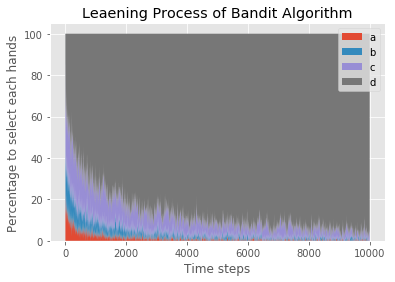

In [42]:
selected_arms = np.array(selected_arms) * 100 #パーセントにキャスト
x = np.arange(TIME_STEP)
# スタックプロット
fig, ax = plt.subplots()
ax.stackplot(x, selected_arms.T, labels=["a","b","c","d"])
plt.legend()
plt.title("Leaening Process of Bandit Algorithm")
plt.xlabel("Time steps")
plt.ylabel("Percentage to select each hands")
plt.show()

## シングルエージェント強化学習

### 環境構築

In [2]:
A = np.array(["入口に戻る", "東", "西"])
S = np.array(["山賊","湖","入口","森","宝"])
#R(s,a,s′): ここは問題によって引数も値も変わる．今回は遷移先の状態のみを見る
reward = {"山賊":-10,"湖":0,"入口":0,"森":0,"宝":10}
#遷移テーブル
ENV = pd.DataFrame({"入口に戻る": ["入口", np.NaN, np.NaN, np.NaN,"入口"], "東":[np.NaN,"入口","森","宝", np.NaN], "西":[np.NaN,"山賊","湖","入口", np.NaN]}, index=S)

### 行動選択手法
ref : マルチエージェント学習 p.28 高玉圭樹

In [3]:
#グリーディ方策
def greedy(q_row):
    """
    @param q_row q_table row of object state s
    @return selected action arg
    """
    return np.nanargmax(q_row)

In [4]:
#イプシロングリーディ方策
def eps_greedy(q_row, eps=0.1):
    """
    @param q_row q_table row of object state s
    @param eps random probability parameter
    @return selected action arg
    """
    prob = np.random.rand()
    if prob <= eps:
        return np.random.choice(np.where(np.invert(np.isnan(q_row)))[0])
    else:
        return np.nanargmax(q_row)

In [5]:
#ボルツマンソフトマックス方策
def softmax_boltzman(q_row, T=1.0):
    """
    @param q_row q_table row of object state s
    @param T temperature parameter
    @return selected action arg
    """
    obj = np.arange(len(q_row))[np.invert(np.isnan(q_row))]
    q_row = q_row[np.invert(np.isnan(q_row))]
    #TODO Tの温度管理を実装
    return np.random.choice(obj, p=(np.exp(q_row / T))/np.sum(np.exp(q_row / T)))

In [6]:
#ルーレットソフトマックス方策
#Q値がマイナスをとるときは適用不可能
def softmax_roulette(q_row):
    """
    @param q_row q_table row of object state s
    @return selected action arg
    """
    obj = np.arange(len(q_row))[np.invert(np.isnan(q_row))]
    q_row = q_row[np.invert(np.isnan(q_row))]
    return np.random.choice(obj, p=q_row / np.sum(q_row))

In [7]:
#ランダム方策
def random_select(q_row):
    """
    @param q_row q_table row of object state s
    @return selected action arg
    """
    obj = np.arange(len(q_row))[np.invert(np.isnan(q_row))]
    return np.random.choice(obj)

### 学習手法(ブートストラップ型学習)
ref : マルチエージェント学習 p.35 高玉圭樹

In [10]:
#Q学習
def q_learning(S, A, s_0, s_t, n_iter=1000):
    """
    @param S state set
    @param A action set
    @param s_0 initial state
    @param s_t terminal state
    @param n_iter iteration number
    @return reward list of each timestep
    @return q value table
    """
    gamma = 0.9
    #initialize q_table
    q_table = ENV.copy()
    q_table[q_table.notnull()] = 1
    #q_table = pd.DataFrame(np.ones(len(S), len(A)), index=S, columns=A) #optimistic initial value
    #q_table = pd.DataFrame(np.ones(len(S), len(A)) * (-1), index=S, columns=A) #pessimistic initial value
    reward_lst = []
    for k in range(n_iter):
        alpha = 1/(k+1) #0.1
        s = s_0
        total_r = 0
        while not s == s_t:
            a_arg = softmax_boltzman(np.array(q_table.loc[s].copy(), dtype=np.float64), T=1.5)
            a = A[a_arg]
            s_next = ENV[a][np.where(S==s)[0][0]]
            r = reward[s_next] - 1
            total_r += r
            q_table[a][s] += alpha * (r + gamma * np.nanmax(np.array(q_table.loc[s_next], dtype=np.float64)) - q_table[a][s])
            s = s_next
        reward_lst.append(total_r)
    return reward_lst, q_table

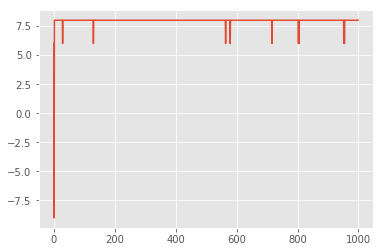

In [11]:
r, q = q_learning(S, A, "入口", "宝", 1000)
plt.plot(range(1000), r)

In [12]:
#Sarsa
def Sarsa(S, A, s_0, s_t, n_iter=1000):
    """
    @param S state set
    @param A action set
    @param s_0 initial state
    @param s_t terminal state
    @param n_iter iteration number
    @return reward list of each timestep
    @return q value table
    """
    gamma = 0.9
    #initialize q_table
    q_table = ENV.copy()
    q_table[q_table.notnull()] = 1
    #q_table = pd.DataFrame(np.ones(len(S), len(A)), index=S, columns=A) #optimistic initial value
    #q_table = pd.DataFrame(np.ones(len(S), len(A)) * (-1), index=S, columns=A) #pessimistic initial value
    reward_lst = []
    for k in range(n_iter):
        alpha = 1/(k+1) #0.1
        s = s_0
        a_arg = softmax_boltzman(np.array(q_table.loc[s].copy(), dtype=np.float64), T=1.5)  #change these 2 method
        a = A[a_arg]
        total_r = 0
        while not s == s_t:
            s_next = ENV[a][np.where(S==s)[0][0]]
            r = reward[s_next] - 1
            total_r += r
            a_arg = softmax_boltzman(np.array(q_table.loc[s_next].copy(), dtype=np.float64), T=1.5) #change these 2 method, but s_next
            a_next = A[a_arg]
            q_table[a][s] += alpha * (r + gamma * q_table[a_next][s_next] - q_table[a][s])
            s = s_next
            a = a_next
        reward_lst.append(total_r)
    return reward_lst, q_table

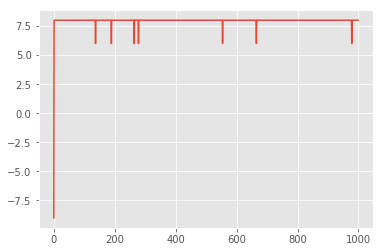

In [13]:
r,q = Sarsa(S, A, "入口", "宝", 1000)
plt.plot(range(1000), r)

In [14]:
#バケツリレー・アルゴリズム
def simple_bucket_brigade(S, A, s_0, s_t, c_bid = 0.1 ,n_iter=1000):
    """
    caution:
    ここで扱っているバケツリレーアルゴリズムはp. 47で紹介されたシンプルなものである
    オリジナルのモデルではドントケアなどが組み込まれている ref : p.49
    """
    """
    @param S state set
    @param A action set
    @param s_0 initial state
    @param s_t terminal state
    @param c_bid bid patameter
    @param n_iter iteration number
    @return reward list of each timestep
    @return q value table
    """
    #initialize q_table
    q_table = ENV.copy()
    q_table[q_table.notnull()] = 1
    #q_table = pd.DataFrame(np.ones(len(S), len(A)), index=S, columns=A) #optimistic initial value
    #q_table = pd.DataFrame(np.ones(len(S), len(A)) * (-1), index=S, columns=A) #pessimistic initial value
    reward_lst = []
    for k in range(n_iter):
        s = s_0
        bid_table = c_bid * q_table.copy()
        a_arg = softmax_boltzman(np.array(bid_table.loc[s].copy(), dtype=np.float64), T=1.5)  #change these 2 method
        a = A[a_arg]
        total_r = 0
        while not s == s_t:
            s_next = ENV[a][np.where(S==s)[0][0]]
            r = reward[s_next] - 1
            total_r += r
            bid_table.loc[s_next] =  c_bid * q_table.copy().loc[s_next]
            a_arg = softmax_boltzman(np.array(bid_table.loc[s_next].copy(), dtype=np.float64), T=1.5) #change these 2 method, but s_next
            a_next = A[a_arg]
            q_table[a][s] += (r + bid_table[a_next][s_next] - bid_table[a][s])
            s = s_next
            a = a_next
        reward_lst.append(total_r)
    return reward_lst, q_table

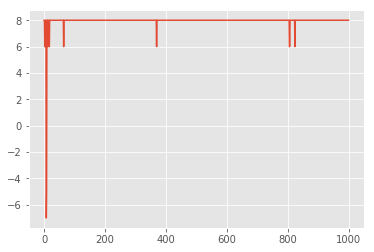

In [15]:
r,q = simple_bucket_brigade(S, A, "入口", "宝", n_iter=1000)
plt.plot(range(1000), r)

In [ ]:
# #TD学習
# def TD():
#     """
#     必要かな？とりあえず保留
#     """

### 学習手法(非ブートストラップ型学習)
ref : マルチエージェント学習 p.51 高玉圭樹

In [33]:
#モンテカルロ法
"""
適用した問題に問題がある(各タイムステップごとの-1してしまっているので毎回報酬が発生する)ので，うまくいかない
if not(r==-1) ~の処理を毎回行うように変更するとそこそこの学習が行われる
"""
def MonteCarlo(S, A, s_0, s_t, n_iter=1000):
    q_table = ENV.copy()
    q_table[q_table.notnull()] = 1 #Q tableの初期化

    sum_reward = q_table.copy()
    sum_reward[sum_reward.notnull()] = 0 #sum reward tableの初期化
    
    reward_count = sum_reward.copy()

    reward_lst = []
    for k in range(n_iter):
        s = s_0
        total_r = 0
        action_lst = []
        while not s == s_t:
            a_arg = softmax_boltzman(np.array(q_table.loc[s].copy(), dtype=np.float64), T=1.5)
            a = A[a_arg]
            s_next = ENV[a][np.where(S==s)[0][0]]
            action_lst.append((a, s))
            r = reward[s_next] - 1
            total_r += r
            if not(r == -1): #time stepに罰をかけてるから-1になる．本来は0で報酬獲得なしを意味したかった
                for a_t, s_t in action_lst:
                    reward_count[a_t][s_t] +=  1
                    sum_reward[a_t][s_t] += r
                    q_table[a_t][s_t] = sum_reward[a_t][s_t] / reward_count[a_t][s_t] #ほんとはuniqueにすべきだけど今回は許容
                action_lst = []
            s = s_next
        reward_lst.append(total_r)
    return reward_lst, q_table

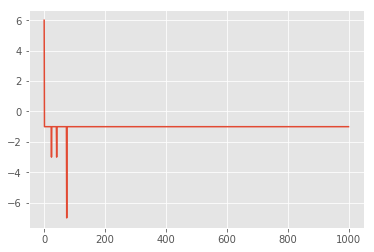

In [37]:
r,q = MonteCarlo(S, A, "入口", "宝", n_iter=1000)
plt.plot(range(1000), r)

In [ ]:
#Profit Sharing
def ProfitSharing():

## マルチエージェント強化学習

### n人繰り返し囚人のジレンマ(n=2)
n人(n>2)に拡張するときの報酬体系は[こちら](https://www.jstage.jst.go.jp/article/sicetr/49/3/49_370/_pdf)を参考に

参考文献
["学習あり繰り返し囚人のジレンマにおける協調行動の発生", JSAI 2014](https://kaigi.org/jsai/webprogram/2014/pdf/699.pdf)

In [12]:
#なんかよくわからんsoftmax
def psuedo_reward(A, act_history, reward_history, alpha, beta=1.0):
    """
    @param A action set
    @param act_history action history (length K) 
    @param  reward_history reward history (length K)
    @param alpha learning parameter
    @return selected action
    """
    def gamma(x, y):
        if x == y:
            return 1
        return 0
    
    K = len(act_history)
    R = np.array([0,0])
    R[0] = np.sum([alpha ** k * gamma("0", act_history[k-1]) * reward_history[k-1] for k in range(1, K+1)])
    R[1] = np.sum([alpha ** k * gamma("1", act_history[k-1]) * reward_history[k-1] for k in range(1, K+1)])
    
    return np.random.choice(["0", "1"], p=(np.exp(R * beta))/np.sum(np.exp(R * beta)))

In [13]:
class Agent:
    def __init__(self, A, agent_id, K):
        self.A = A
        self.agent_id = agent_id
        self.reward = 0
        self.K = K
        self.reward_history = [0] * K
        self.act_history = [""] * K
        
    def reinit(self):
        self.reward = 0
        self.reward_history = [0] * self.K
        self.act_history = [""] * self.K
    
    def random_act(self):
        action = np.random.choice(self.A)
        self.act_history = [action] + self.act_history[:self.K-1]
        return action
    
    def act(self, alpha):
        action = psuedo_reward(self.A, self.act_history, self.reward_history, alpha)
        self.act_history = [action] + self.act_history[:self.K-1]
        return action
        
    def add_reward(self, reward):
        self.reward += reward
        self.reward_history = [reward] + self.reward_history[:self.K-1]

In [14]:
#繰り返し囚人のジレンマゲーム
class IPD:
    def __init__(self, K=10):
        self.K = K
        self.reward_func = {"00":2,"01":0,"10":3,"11":1}
        self.agent0 = Agent(["0", "1"], 0, self.K)
        self.agent1 = Agent(["0", "1"], 1, self.K)
        self.history = []
        
    def run(self, n_iter, alpha=1.0):
        for i in tqdm(range(n_iter)):
            if i < self.K:
                act0 = self.agent0.random_act()
                act1 = self.agent1.random_act()
            else:
                act0 = self.agent0.act(alpha)
                act1 = self.agent1.act(alpha)
                
            reward0 = self.reward_func[act0+act1]
            reward1 = self.reward_func[act1+act0]

            self.agent0.add_reward(reward0)
            self.agent1.add_reward(reward1)
            
            self.history.append(act0+act1)
        
    def reinit(self):
        self.agent0.reinit()
        self.agent1.reinit()
        self.history = []

In [15]:
demo = IPD()
demo.run(50, alpha=1.0)
count_dict = collections.Counter(demo.history)
print(count_dict)

Counter({'11': 38, '01': 5, '00': 4, '10': 3})


In [16]:
#繰り返し行き詰まりゲーム
class IDG:
    def __init__(self, K=10):
        self.K = K
        self.reward_func = {"00":1,"01":0,"10":3,"11":2}
        self.agent0 = Agent(["0", "1"], 0, self.K)
        self.agent1 = Agent(["0", "1"], 1, self.K)
        self.history = []
        
    def run(self, n_iter, alpha=1.0):
        for i in tqdm(range(n_iter)):
            if i < self.K:
                act0 = self.agent0.random_act()
                act1 = self.agent1.random_act()
            else:
                act0 = self.agent0.act(alpha)
                act1 = self.agent1.act(alpha)
                
            reward0 = self.reward_func[act0+act1]
            reward1 = self.reward_func[act1+act0]

            self.agent0.add_reward(reward0)
            self.agent1.add_reward(reward1)
            
            self.history.append(act0+act1)
        
    def reinit(self):
        self.agent0.reinit()
        self.agent1.reinit()
        self.history = []

In [17]:
demo = IPD()
demo.run(50, alpha=0.7)
count_dict = collections.Counter(demo.history)
print(count_dict)

Counter({'11': 23, '01': 21, '10': 3, '00': 3})


### 繰り返し囚人のジレンマ+複雑ネットワーク
参考文献 ["不均質な環境における拡張協調期待戦略の効率と特性", 計算社会科学研究会 Technical Report](http://css-japan.com/wp-content/uploads/2017/02/05.CSSJWS.pdf)

### 完全グラフの場合
実験条件　エージェント数300
### 正則グラフの場合
実験条件　エージェント数1000，平均次数10

以下の実装は非同期のn人繰り返し囚人のジレンマだが，本当は同期型っぽい？(実験が再現できなかった)

直すとしたら隣接行列を取得して，np.whereで1の位置を特定し，randomな順で選択する．(そんな労力をかけても仕方ないから一旦やめる)

In [2]:
class world:
    def __init__(self, n_coop_agent, n_round):
        self.n_coop_agent = n_coop_agent
        self.n_round = n_round
        self.payoff_matrix = {'00':3, '01':0, '10':5, '11':1}
        self.create_network(n_coop_agent)
        
    def create_network(self, n_coop_agent):
        self.G = nx.complete_graph(n_coop_agent)
        self.n_edges = 0
        for n in self.G.nodes():
            self.n_edges += len(self.G.neighbors(n))
            agent = Coop_Agent(n, sorted(self.G.neighbors(n)))
            self.G.node[n]["agent"] = agent
            self.G.node[n]["reward"] = []
            self.G.node[n]["action"] = 0
            
    def run_w_viz(self):
        """
        グラフの変化をgifで保存
        """
        fig = plt.figure(figsize=(5,4))
        anim = animation.FuncAnimation(fig, self.update, frames=self.n_round)
        anim.save("demo.gif", writer="imagemagick", fps=4)
        
    def update(self, i):
        """
        グラフの変化をアニメーションとして保存するようの実行関数
        """
        for _ in range(10):
            round_action_lst = []
            q_tables = []
            n_coop_edges = 0
            #行動選択
            for n in  self.G.nodes():
                self.G.node[n]["action"] = self.G.node[n]["agent"].act()
                round_action_lst.append(self.G.node[n]["action"])

            round_action_lst = np.array(round_action_lst)

            #報酬計算&Q値更新
            for n in self.G.nodes():
                neighbors = self.G.node[n]["agent"].get_neighbors()
                n_action = str(self.G.node[n]["action"])
                r_lst = []
                for ne in neighbors:
                    ne_action = str(self.G.node[ne]["action"])
                    r_lst.append(self.payoff_matrix[n_action+ne_action])
                    if n_action == "0" and ne_action == "0":
                        n_coop_edges += 1

                self.G.node[n]["reward"] = r_lst
                q = self.G.node[n]["agent"].update_q(r_lst, int(n_action))
                q_tables.append(np.average(q, axis=0))         
                
        color = ["r" if self.G.node[n]["action"] == 0 else "b" for n in self.G.nodes()]
        nx.draw(self.G, pos=nx.circular_layout(self.G), node_color=color)
        
    def run(self):
        for i in range(self.n_round):
            round_action_lst = []
            #行動選択
            for n in  self.G.nodes():
                self.G.node[n]["action"] = self.G.node[n]["agent"].act()
                round_action_lst.append(self.G.node[n]["action"])
            round_action_lst = np.array(round_action_lst)
            #報酬計算&Q値更新
            for n in self.G.nodes():
                neighbors = self.G.node[n]["agent"].get_neighbors()
                n_action = str(self.G.node[n]["action"])
                r_lst = []
                for ne in neighbors:
                    ne_action = str(self.G.node[ne]["action"])
                    r_lst.append(self.payoff_matrix[n_action+ne_action])
                self.G.node[n]["reward"] = r_lst
                q = self.G.node[n]["agent"].update_q(r_lst, int(n_action))
        color = ["r" if self.G.node[n]["action"] == 0 else "b" for n in self.G.nodes()]
        nx.draw(self.G, pos=nx.circular_layout(self.G), node_color=color)

In [3]:
class Coop_Agent(object):
    def __init__(self, agent_id, neighbors, L=1, alpha=0.1, eps=0.05):
        """
        @param agent_id agent id, int
        @param neighbors neighbor agent ids, int array
        """
        self.agent_id = agent_id
        self.neighbors = neighbors
        self.alpha = alpha
        self.eps = eps
        self.n_run = 0
        self.q_table = np.zeros((len(neighbors), 2))
        self.priority = [0, 0]
        self.L = L
        self.L_count = 0
        
    def re_init(self):
        """
        @function initialize agent parameter
        """
        self.q_table = np.zeros((len(neighbors), 2))
        self.action_history = []
        self.priority = [0, 0]
    
    def act(self):
        """
        @function select agent action
        @return selected action
        """
        if self.L_count > 0:
            self.L_count -= 1
            action = 0
        else:
            if np.random.rand() > self.eps and self.n_run >= 6:
                s = np.argmax(self.q_table, axis=1) #s(t-1)を求める(3)
                self.priority[0] = np.sum([self.delta(0, s_j) for s_j in s])
                self.priority[1] = np.sum([self.delta(1, s_j) for s_j in s]) #pを更新 (2)
                action = np.argmax(self.priority) #行動選択(1)
            else:
                action = np.random.choice([0, 1]) #eps-greedyな戦略
        self.n_run += 1
        return action
    
    def update_q(self, reward_lst, prev_action):
        """
        @function update q value of each neighbor agents
        @return q table
        """
        #協調チェックを追加
        if 3 in reward_lst: #CCの戦略によって得られる報酬がreward_lstにあれば
            self.L_count = self.L
        reward_table = np.zeros(self.q_table.shape)
        reward_table[:, prev_action] = np.array(reward_lst)
        self.q_table = (1-self.alpha) * self.q_table + self.alpha * reward_table
        return self.q_table
        
    def delta(self, s1, s2):
        """
        @function delta function
        @return boolean
        """
        return int(s1 == s2)
        
    def get_neighbors(self):
        """
        @return neighbor's agent id lst
        """
        return self.neighbors
    
    def get_id(self):
        return self.agent_id

/Users/yamazakitakurou/.pyenv/versions/3.5.2/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/yamazakitakurou/.pyenv/versions/3.5.2/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/yamazakitakurou/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/yamazakitakurou/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: U

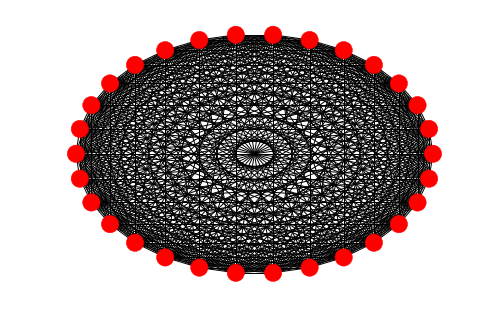

In [4]:
a = world(30, 300)
a.run()

### 群強化学習＋繰り返し囚人のジレンマ
参考文献 [マルチエージェントタスクに対する群強化学習法](https://www.jstage.jst.go.jp/article/sicetr/49/3/49_370/_pdf)

- 群強化学習とマルチエージェント強化学習の違い

- 環境に対して複数のエージェントが存在し，それぞれが個別に強化学習を行うことでエージェント全体の目的を達成するものがマルチエージェント強化学習

- 複数の学習世界を用意し，各学習世界で個別に学習するとともに，望みの学習に有用な情報を学習世界間で交換しながら学習することが群強化学習